**Цель проекта:** система классификации типа математической задачи

**Команда проекта:**

  * Кулибаба Степан

  * Пирахмедов Тимур

  * Акатов Даниил



---

Github проекта - [Github](https://github.com/kulibabast/Classifier-of-mathematical-problems)

In [ ]:
!pip install pymorphy2
!python -m spacy download ru_core_news_sm
!pip install yargy

In [ ]:
import requests
import pandas as pd
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pymorphy2
import os
import re
from bs4 import BeautifulSoup
from google.colab import drive, userdata
import numpy as np
import pandas
import requests
import time
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import unicodedata
import spacy
import string
from nltk import FreqDist
from nltk.util import ngrams
from string import ascii_letters
from gensim.models import Word2Vec as w2v
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_to_folder = userdata.get('path_to_folder_ppsh')

# Парсинг данных
материал:

    https://www.problems.ru/
    https://mathus.ru/

In [ ]:
data = pd.DataFrame({"Путь до файла": [],
                     "Тема": []})

## Mathus

In [ ]:
def list_files_in_directory(directory):
    global data
    if not os.path.exists(directory):
        print(f"Директория '{directory}' не существует.")
        return

    for root, dirs, files in os.walk(directory):
        print(f"Папка: {root}")
        path_to_file = []
        for file in files:
            path_to_file.append(os.path.join(root, file))
            print(file)

        data = pd.concat([data, pd.DataFrame({"Путь до файла": path_to_file,
                          "Тема": [root.split('/')[-1]]*len(path_to_file)})])

directory_path = path_to_folder + '/Dataset/Parsing/'
list_files_in_directory(directory_path)

Папка: /content/drive/MyDrive/Проекты/ППШ/Dataset/Parsing/
Папка: /content/drive/MyDrive/Проекты/ППШ/Dataset/Parsing/Оценка+пример
Оценка+Пример-1.txt
Оценка+Пример-2.txt
Папка: /content/drive/MyDrive/Проекты/ППШ/Dataset/Parsing/Инвариант 
invariant.txt
Папка: /content/drive/MyDrive/Проекты/ППШ/Dataset/Parsing/Многочлен
polynom.txt
Папка: /content/drive/MyDrive/Проекты/ППШ/Dataset/Parsing/Комбинаторика 
sumprod.txt
apc.txt
Папка: /content/drive/MyDrive/Проекты/ППШ/Dataset/Parsing/Теория чисел
07-euclid.txt
02_malaja_teorema_Ferma_upr.txt
nodinok.txt
ostear.txt
Папка: /content/drive/MyDrive/Проекты/ППШ/Dataset/Parsing/Дирихле
dirihle.txt
pridir.txt
Папка: /content/drive/MyDrive/Проекты/ППШ/Dataset/Parsing/Геометрия
геома.txt
2016_04_28_gomotetia.txt


In [ ]:
data_with_task = pd.DataFrame({"Задача": [], "Тема": []})
pattern = re.compile(r'\b\d+[.)]\s*(?:\([^)]*\))?.*?(?=(?:\b\d+[.)])|\b\d+\s*-\s*\d+[.)])', re.DOTALL)

for index, row in data.iterrows():
  with open(row['Путь до файла'], 'r') as f:
      text = f.read()
  task = pattern.findall(text)
  data_with_task = pd.concat([data_with_task,
                              pd.DataFrame({"Задача": task,
                                            "Тема": [row['Тема']]*len(task)})])

In [ ]:
data_with_task = data_with_task.reset_index().drop(columns=['index'])

In [ ]:
data_with_task

,Задача,Тема
0,1. Какое наибольшее число трёхклеточных уголко...,Оценка+пример
1,"66. Значит, число уголков не\nбольше 21 (оценк...",Оценка+пример
2,"21.\n Логика рассуждения ясна: мы показали, ...",Оценка+пример
3,2. Каким наименьшим числом монет в 3 и 5 копее...,Оценка+пример
4,40). Семь\nпятикопеечных монет и одна трёхкопе...,Оценка+пример
...,...,...
1387,6. Даны угол 𝐴𝐵𝐶 и точка 𝑀 внутри его. Построй...,Геометрия
1388,7. Две окружности касаются в точке 𝐾. Через то...,Геометрия
1389,8. На каждом из оснований 𝐴𝐷 и 𝐵𝐶 трапеции 𝐴𝐵𝐶...,Геометрия
1390,9. Четырёхугольник разрезан диагоналями на чет...,Геометрия


In [ ]:
data_with_task.groupby('Тема').agg('count')

,Задача
Тема,
Геометрия,78
Дирихле,44
Инвариант,46
Комбинаторика,264
Многочлен,369
Оценка+пример,325
Теория чисел,266


In [ ]:
data_with_task.to_csv('data.csv', sep='@')

## Problems

In [ ]:
data_problems = pd.DataFrame({'Задача': [], "Тема": []})
PROBLEMS = 'https://www.problems.ru/view_by_subject_new.php?parent={}&start={}'
url = ((192, 'Графы'),
       (603, 'Геометрия'), (379, 'Геометрия'), (381, 'Геометрия',), (382, 'Геометрия',), (404, 'Геометрия',),
       (1902, 'Оценка+пример'),
       (110, 'Многочлен'), (160, 'Многочлен'), (1286, 'Многочлен'), (958, 'Многочлен'), (1069, 'Многочлен'), (1069, 'Многочлен'),
       (188, "Комбинаторика"),
       (134, 'Теория чисел'),
       (220, 'Инвариант'),
       (216, "Дирихле")
       )

old_paragraph_list = [0]
for urls in url:
    for page in tqdm(range(0, 10**3, 5)):

        url_s = PROBLEMS.format(urls[0], page)
        response = requests.get(url_s)

        html = response.content

        soup = BeautifulSoup(html, 'html.parser')
        paragraphs = soup.find_all('p')

        paragraph_list = [paragraph.get_text() for paragraph in paragraphs if paragraph.get_text()]

        if old_paragraph_list == paragraph_list:
          break
        old_paragraph_list = paragraph_list

        data_problems = pd.concat([data_problems, pd.DataFrame({'Задача': paragraph_list,
                                                                "Тема": urls[1]})])

        time.sleep(1.5)

NameError: ignored

In [ ]:
data_problems = data_problems.drop_duplicates()

In [ ]:
data_problems.to_excel('data_problems.xlsx')

In [ ]:
data_problems.groupby('Тема').agg('count')

,Задача
Тема,
Геометрия,371
Графы,384
Дирихле,441
Инвариант,235
Комбинаторика,280
Многочлен,426
Теория чисел,50


# DataCleaning

In [ ]:
mathus = pd.read_csv(path_to_folder + '/Dataset/MathUs.csv', sep='@').drop(columns=['Unnamed: 0'])
problems = pd.read_excel(path_to_folder + '/Dataset/data_problems.xlsx').drop(columns=['Unnamed: 0'])\
            .rename(columns={"Задача": "Задание"})
data = pd.concat([mathus, problems])

In [ ]:
data.to_csv('merge_data.csv', sep='@')

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data.groupby("Тема").agg('count')

,Задание
Тема,
Геометрия,426
Графы,384
Дирихле,479
Инвариант,267
Комбинаторика,419
Многочлен,485
Оценка+Пример,65
Теория чисел,157


In [ ]:
data.rename(columns={'Задание': 'task',
                     'Тема': 'topic'},
            inplace=True)

In [ ]:
nlp = spacy.load("ru_core_news_sm")

In [ ]:
def del_garbage(text):
    return text.strip('.,)?.<*&^%$#@!~')\
               .replace(u'\u00A0', ' ')\
               .replace(u'\x0c', ' ')\
               .replace('\n', '').replace('\t', '')\
               .replace('\r', '')

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def filters_dig(text):
    help_text = text.split()
    if len(text.replace(' ', '')) > 1 and '\xa0' not in text and len(help_text) > 1:
      try:
        if help_text[0] == 'Задача':
          return text[text.find(')')+1:]
        float(help_text[0][:-1])
        if help_text[1][0] == '(':
          return text[text.find(')')+1:]
        return " ".join(help_text[1:])
      except (SyntaxError, ValueError):
        return text
    else:
      return text

def lemmatize_text(text):
    global nlp
    doc = nlp(text)
    lemmatized_text = ' '.join([token.lemma_ for token in doc if not token.is_stop])
    return lemmatized_text

def preprocessing_text(text):
    text = filters_dig(text)
    text = del_garbage(text).lower()
    text = lemmatize_text(text)

    return text

data['new_task'] = data.task.apply(preprocessing_text)
data['new_task'] = data.new_task.apply(remove_punctuation)

In [ ]:
data

,task,topic,new_task
0,"1. Если прямая содержит центр гомотетии, то он...",Геометрия,прямой содержать центр гомотетия отображаться
1,"2. Если прямая не содержит центр гомотетии, то...",Геометрия,прямая содержать центр гомотетия отображаться...
2,3. При гомотетии окружность переходит в окружо...,Геометрия,гомотетия окружность переходить окружость
3,"4. Если если есть две окружности, как найти це...",Геометрия,два окружность найти центр коэффициент гомоте...
4,"5. Треугольники 𝐴𝐵𝐶 и 𝐴′ 𝐵 ′ 𝐶 ′ таковы, что 𝐴...",Геометрия,треугольник 𝐴𝐵𝐶 𝐴′ 𝐵 ′ 𝐶 ′ таковы 𝐴𝐵 ‖ 𝐴′ 𝐵 ′...
...,...,...,...
2182,Дьявол предлагает Человеку сыграть в следующую...,Дирихле,дьявол предлагать человек сыграть следующий иг...
2183,По шоссе в одном направлении едут 10 автомобил...,Дирихле,шоссе направление ехать 10 автомобиль шоссе п...
2184,В пространстве имеются 30 ненулевых векторов. ...,Дирихле,пространство иметься 30 ненулевой вектор дока...
2185,На плоскости даны две точки A и B. Пусть C – н...,Дирихле,плоскость дать два точка a b c – точка плоскос...


# EDA

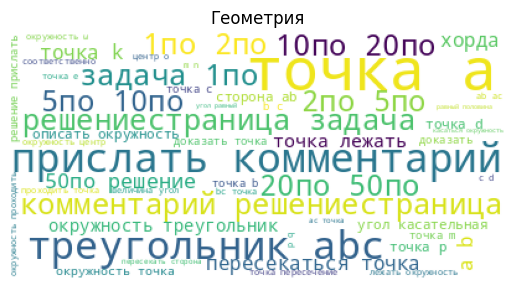

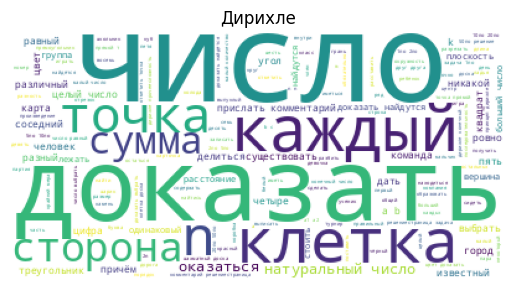

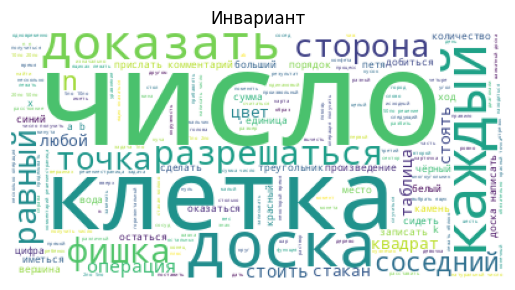

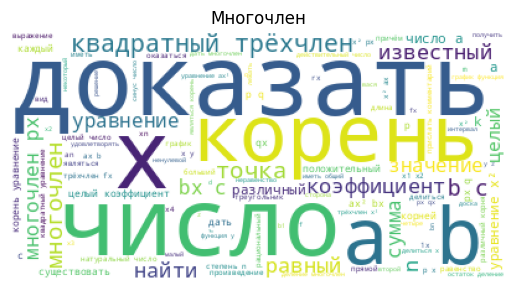

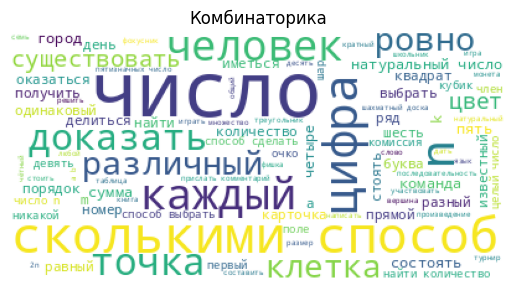

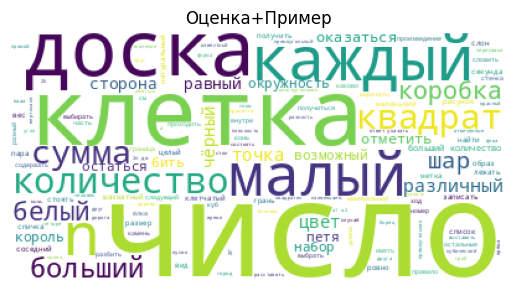

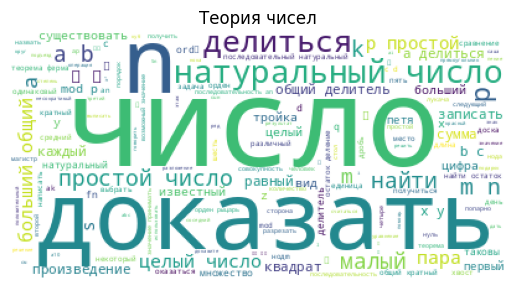

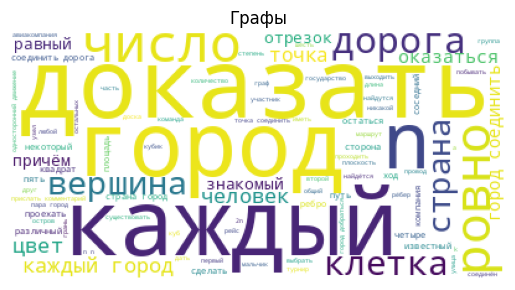

In [ ]:
for topic in data.topic.unique():
    df = data[data.topic == topic]
    text = ' '.join(df['new_task_pros'])
    text_tokens = word_tokenize(text)

    cloud = WordCloud(stopwords=stop_words,
                      background_color='white').generate(' '.join(text_tokens))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(topic)
    plt.show()

**N-grams**

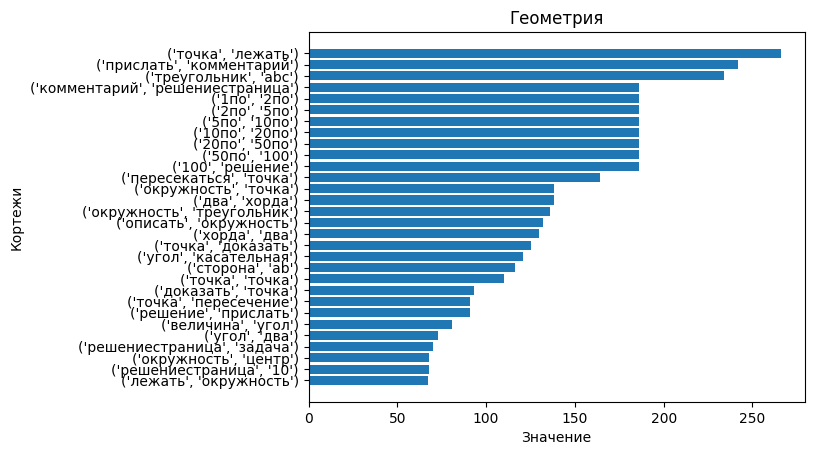

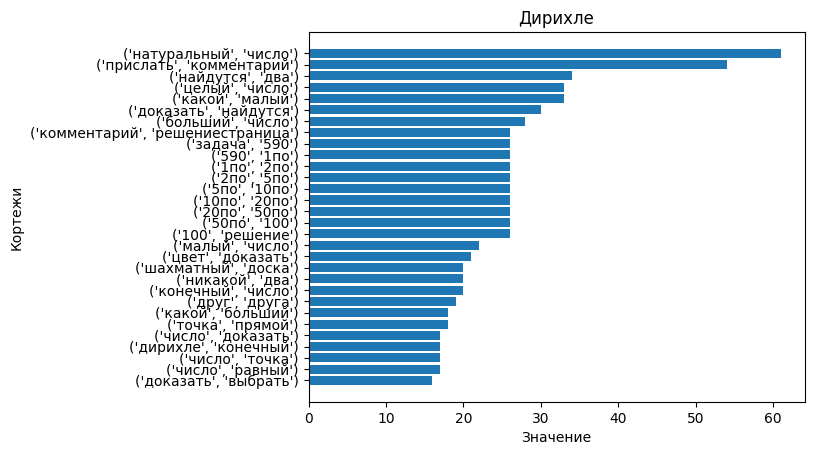

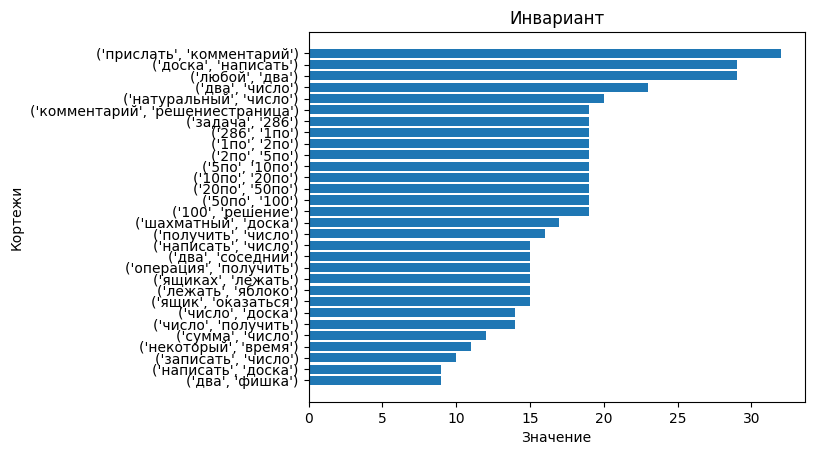

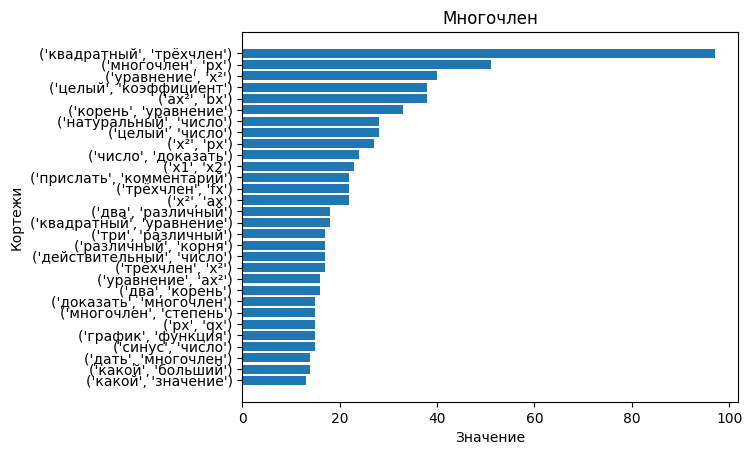

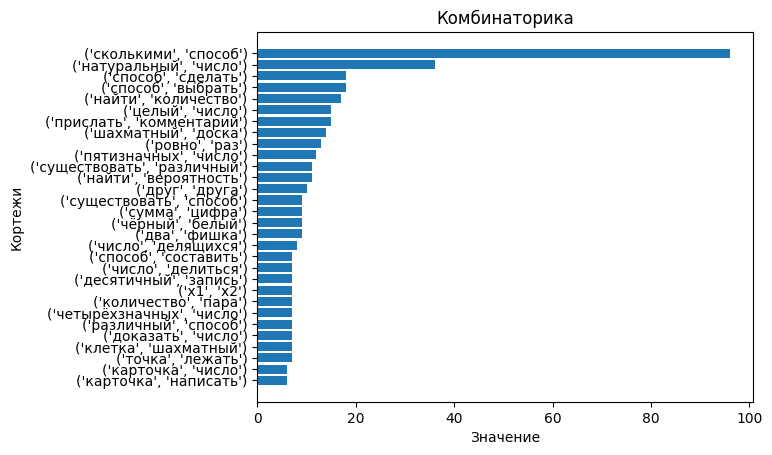

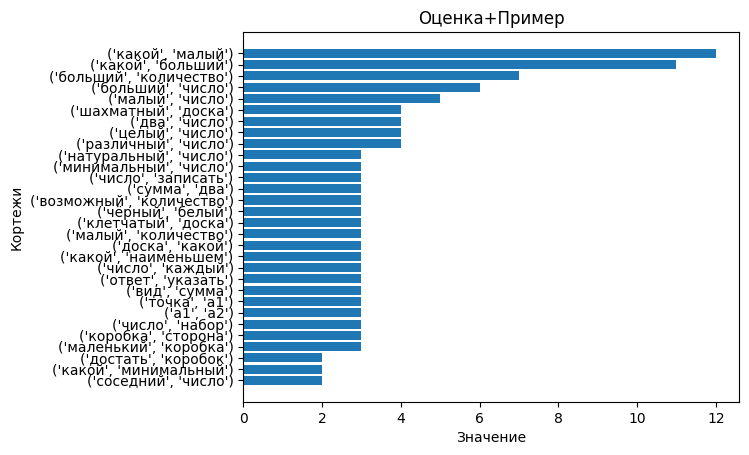

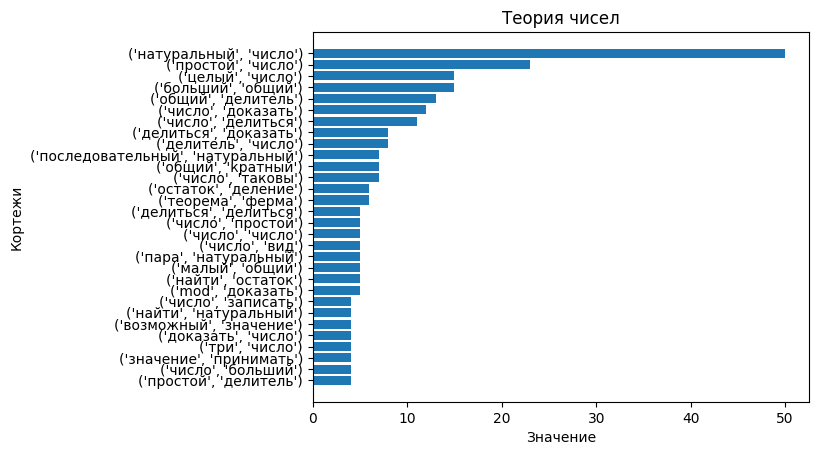

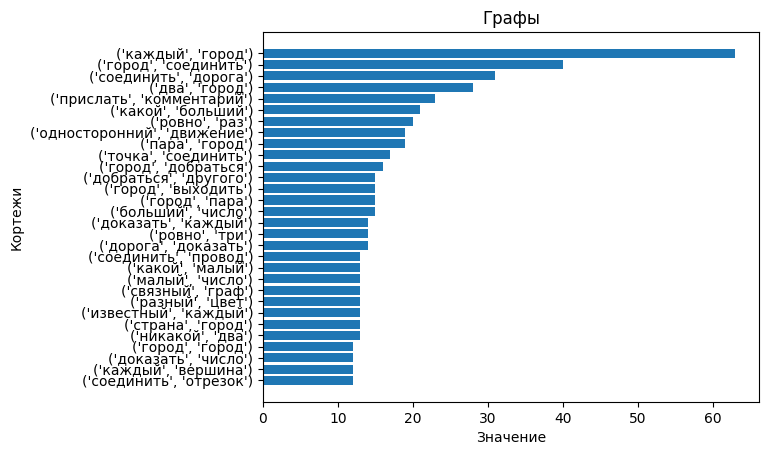

In [ ]:
k = 30
n = 2
for topic in data.topic.unique():
    df = data[data.topic == topic]
    words = ' '.join(df.new_task_pros)
    words = ' '.join(list(filter(lambda x: len(x) >= 2, (words.split()))))
    tokens = nltk.word_tokenize(words)

    ngrams_list = list(ngrams(tokens, n))
    freq_dist = dict(FreqDist(ngrams_list))
    sorted_data = sorted(freq_dist.items(), key=lambda x: -x[1])

    y_labels = [str(key) for key, _ in sorted_data][:k][::-1]
    x_values = [value for _, value in sorted_data][:k][::-1]

    plt.barh(y_labels, x_values)
    plt.xlabel('Значение')
    plt.ylabel('Кортежи')
    plt.title(topic)
    plt.show()

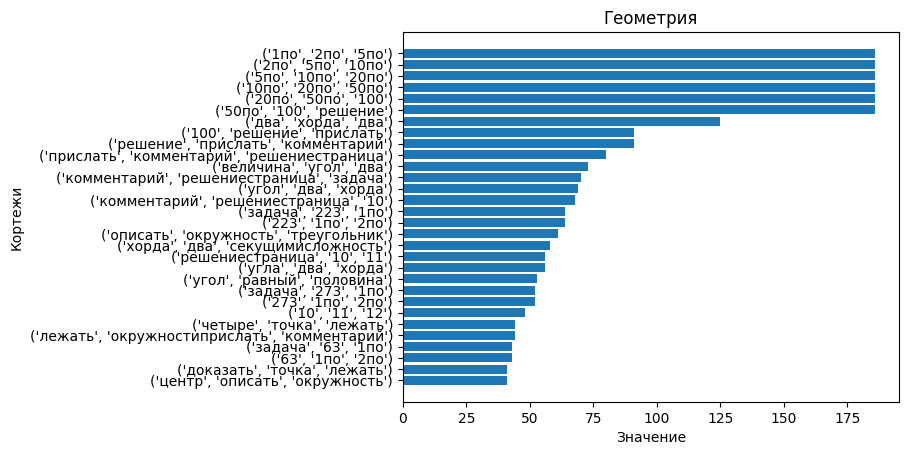

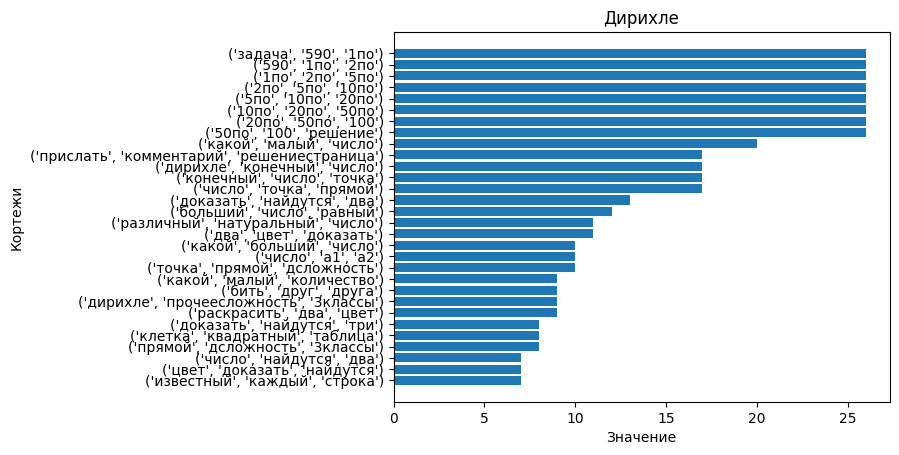

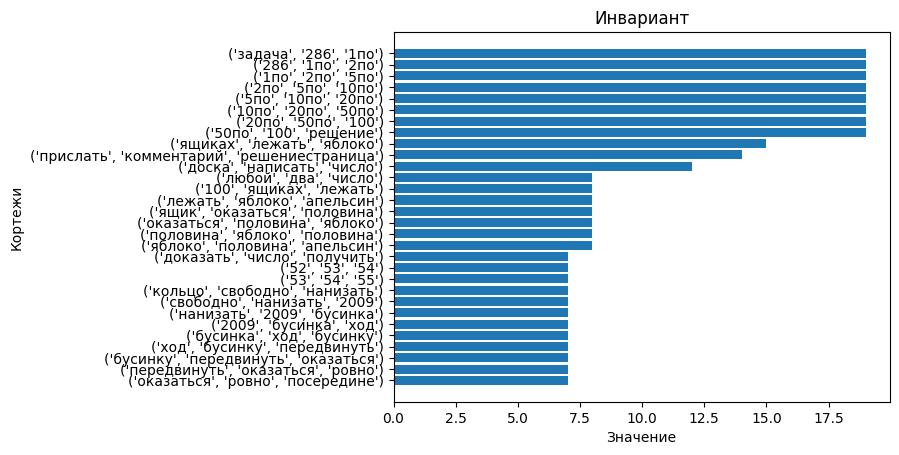

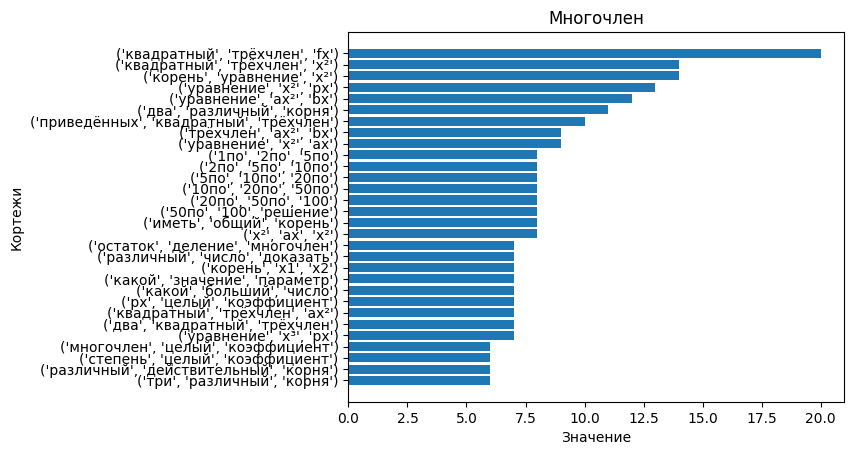

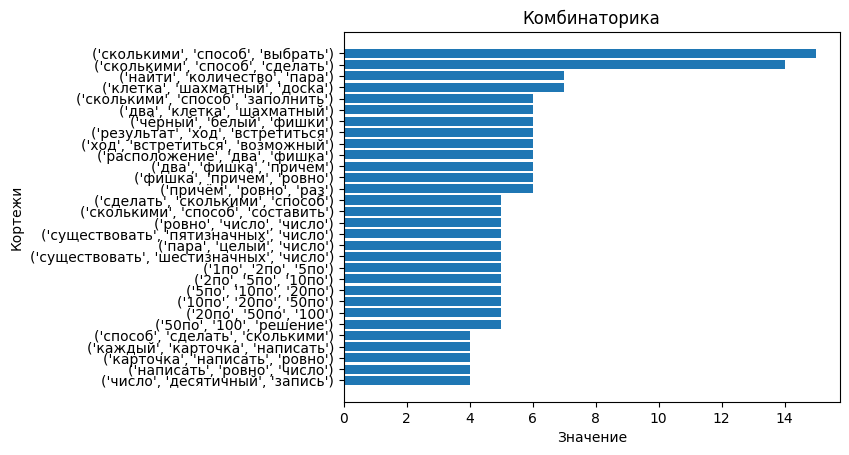

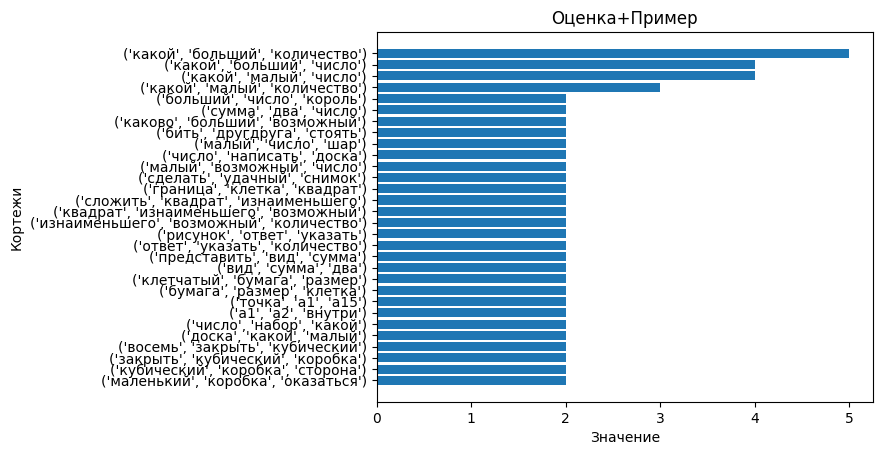

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119886 (\N{MATHEMATICAL ITALIC SMALL A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119909 (\N{MATHEMATICAL ITALIC SMALL X}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119887 (\N{MATHEMATICAL ITALIC SMALL B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119910 (\N{MATHEMATICAL ITALIC SMALL Y}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


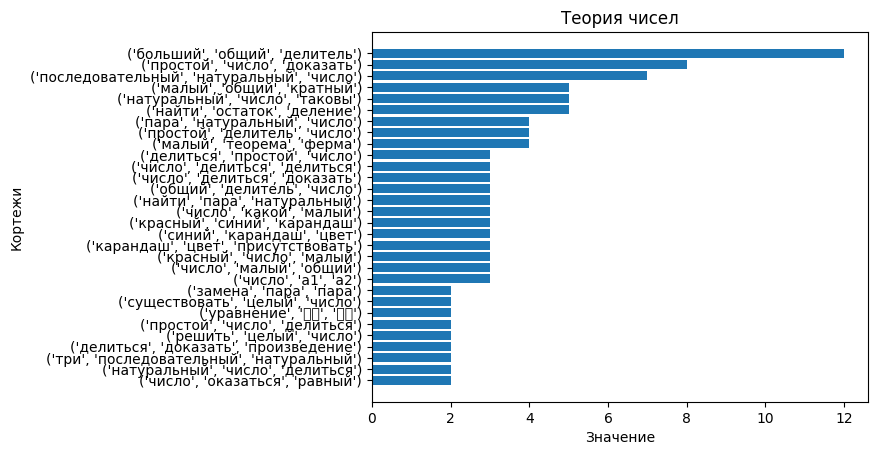

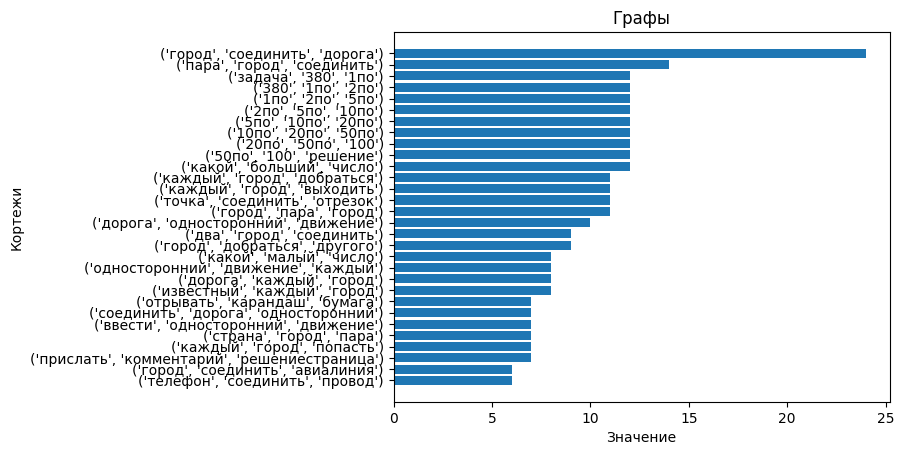

In [ ]:
k = 30
n = 3
for topic in data.topic.unique():
    df = data[data.topic == topic]
    words = ' '.join(df.new_task_pros)
    words = ' '.join(list(filter(lambda x: len(x) >= 2, (words.split()))))
    tokens = nltk.word_tokenize(words)

    ngrams_list = list(ngrams(tokens, n))
    freq_dist = dict(FreqDist(ngrams_list))
    sorted_data = sorted(freq_dist.items(), key=lambda x: -x[1])

    y_labels = [str(key) for key, _ in sorted_data][:k][::-1]
    x_values = [value for _, value in sorted_data][:k][::-1]

    plt.barh(y_labels, x_values)
    plt.xlabel('Значение')
    plt.ylabel('Кортежи')
    plt.title(topic)
    plt.show()

# Preprocessing

In [ ]:
data['y'] = data.topic.apply(lambda topic: topic_dict[topic])

<ipython-input-432-b4578b040dc0>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['y'] = data.topic.apply(lambda topic: topic_dict[topic])


## Word2Vec

In [ ]:
with open(path_to_folder + '/Dataset/978-5-7996-1779-0_2016.txt') as file: math_txt_1 = file.read()
with open(path_to_folder + '/Dataset/978-5-7996-1340-2_2014.txt') as file: math_txt_2 = file.read()

In [ ]:
def to_sentences(text):
    doc = nlp(text)
    return [sent.text for sent in doc.sents]

def txt_to_mas(text):
    return [elem for elem in text.split() \
            if ((len(elem) > 3) and
                len(set(list(ascii_letters) + list(map(str, range(10)))) & set(elem)) == 0)]

def keep_russian_words(text):
    new_text = ''
    for word in text.split():
      if len(set(ascii_letters) & set(word)) == 0:
             new_text += word + " "
    return new_text

def only_russian_words(text):
    pattern = re.compile(r'\b[а-яА-Я]+\b')
    russian_words = pattern.findall(text)
    result_text = ' '.join(russian_words)
    return result_text

def filter_text(text):
    text = del_garbage(text).lower()
    text = lemmatize_text(text)
    return text

def filter_sentences(mas: list):
    mas =  list(map(only_russian_words, mas))
    mas = list(filter(lambda x: len(x.split()) > 5, mas))
    mas = list(map(filter_text, mas))
    return mas

In [ ]:
task_filter = data.new_task.apply(lambda text: del_garbage(filters_dig(text).lower()))
math_text_first = del_garbage(keep_russian_words(" ".join(math_txt_1.split())))
math_text_second = del_garbage(keep_russian_words(" ".join(math_txt_2.split())))

math_text_first_filter = filter_sentences(to_sentences(math_text_first))
math_text_second_filter = filter_sentences(to_sentences(math_text_second))

# -
math_1_ready = list(map(txt_to_mas, math_text_first_filter))
math_2_ready = list(map(txt_to_mas, math_text_second_filter))
task_filter = list(map(txt_to_mas, task_filter))

In [ ]:
learn_mas.extend(math_2_ready)
learn_mas = math_1_ready.copy()
learn_mas.extend(task_filter)
random.shuffle(learn_mas)

In [ ]:
%time model = w2v(sentences=learn_mas, min_count=0)

model.save("word2vec_math_text.model")

CPU times: user 1.55 s, sys: 15 ms, total: 1.56 s
Wall time: 2.28 s


In [ ]:
model.wv.most_similar('математика', topn=5)

[('математик', 0.9992676973342896),
 ('отвечать', 0.9992380142211914),
 ('высказывание', 0.9992116093635559),
 ('стакан', 0.999169647693634),
 ('достаточно', 0.9991090893745422)]

In [ ]:
data

,task,topic,new_task
0,"1. Если прямая содержит центр гомотетии, то он...",Геометрия,прямой содержать центр гомотетия отображаться
1,"2. Если прямая не содержит центр гомотетии, то...",Геометрия,прямая содержать центр гомотетия отображаться...
2,3. При гомотетии окружность переходит в окружо...,Геометрия,гомотетия окружность переходить окружость
3,"4. Если если есть две окружности, как найти це...",Геометрия,два окружность найти центр коэффициент гомоте...
4,"5. Треугольники 𝐴𝐵𝐶 и 𝐴′ 𝐵 ′ 𝐶 ′ таковы, что 𝐴...",Геометрия,треугольник 𝐴𝐵𝐶 𝐴′ 𝐵 ′ 𝐶 ′ таковы 𝐴𝐵 ‖ 𝐴′ 𝐵 ′...
...,...,...,...
2182,Дьявол предлагает Человеку сыграть в следующую...,Дирихле,дьявол предлагать человек сыграть следующий иг...
2183,По шоссе в одном направлении едут 10 автомобил...,Дирихле,шоссе направление ехать 10 автомобиль шоссе п...
2184,В пространстве имеются 30 ненулевых векторов. ...,Дирихле,пространство иметься 30 ненулевой вектор дока...
2185,На плоскости даны две точки A и B. Пусть C – н...,Дирихле,плоскость дать два точка a b c – точка плоскос...


In [ ]:
for i in range(100):
  data[f'vector_{i}'] = 0

for j, text in enumerate(data['new_task']):
  vec = np.zeros(100)
  lens = 0
  for word in word_tokenize(text):
      try:
        vec += model.wv[word]
        lens += 1
      except KeyError:
        continue

  vec /= lens
  for i in range(100):
    data.iloc[j, data.shape[1]-100+i] = vec[i]

<ipython-input-345-e30f2ac20f18>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'vector_{i}'] = 0
<ipython-input-345-e30f2ac20f18>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'vector_{i}'] = 0
<ipython-input-345-e30f2ac20f18>:14: RuntimeWarning: invalid value encountered in divide
  vec /= lens


In [ ]:
data

,task,topic,new_task,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,...,vector_90,vector_91,vector_92,vector_93,vector_94,vector_95,vector_96,vector_97,vector_98,vector_99
0,"1. Если прямая содержит центр гомотетии, то он...",Геометрия,прямой содержать центр гомотетия отображаться,-0.330948,0.190236,0.089476,0.294412,-0.478890,-0.588677,0.536406,...,0.720988,0.114423,-0.125784,0.403357,0.554107,0.283039,0.133370,-0.360992,0.144691,0.010571
1,"2. Если прямая не содержит центр гомотетии, то...",Геометрия,прямая содержать центр гомотетия отображаться...,-0.294148,0.163343,0.080757,0.263465,-0.419465,-0.515020,0.480245,...,0.632770,0.097919,-0.111410,0.355742,0.485203,0.254514,0.120332,-0.320361,0.125951,0.010599
2,3. При гомотетии окружность переходит в окружо...,Геометрия,гомотетия окружность переходить окружость,-0.251178,0.171826,0.066083,0.208745,-0.360737,-0.437618,0.389865,...,0.542963,0.080616,-0.115807,0.296805,0.397929,0.204784,0.083397,-0.247827,0.110986,-0.003292
3,"4. Если если есть две окружности, как найти це...",Геометрия,два окружность найти центр коэффициент гомоте...,-0.322409,0.292580,0.144652,0.266541,-0.427213,-0.720595,0.496503,...,0.755069,0.185428,-0.137014,0.378754,0.597475,0.314258,0.057941,-0.327998,0.177747,-0.021109
4,"5. Треугольники 𝐴𝐵𝐶 и 𝐴′ 𝐵 ′ 𝐶 ′ таковы, что 𝐴...",Геометрия,треугольник 𝐴𝐵𝐶 𝐴′ 𝐵 ′ 𝐶 ′ таковы 𝐴𝐵 ‖ 𝐴′ 𝐵 ′...,-0.285369,0.214850,0.142890,0.228839,-0.269842,-0.576379,0.374447,...,0.560022,0.150987,-0.051665,0.301133,0.456612,0.340378,0.069325,-0.263162,0.148843,-0.020423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2182,Дьявол предлагает Человеку сыграть в следующую...,Дирихле,дьявол предлагать человек сыграть следующий иг...,-0.334260,0.283668,0.212122,0.211383,-0.109483,-0.728783,0.270319,...,0.517929,0.238526,0.055859,0.255284,0.515086,0.496787,0.032259,-0.254335,0.197959,-0.038902
2183,По шоссе в одном направлении едут 10 автомобил...,Дирихле,шоссе направление ехать 10 автомобиль шоссе п...,-0.253303,0.181469,0.115078,0.154006,-0.094918,-0.445441,0.208281,...,0.361063,0.150040,0.037851,0.168979,0.379693,0.374599,0.036667,-0.197829,0.159847,-0.015334
2184,В пространстве имеются 30 ненулевых векторов. ...,Дирихле,пространство иметься 30 ненулевой вектор дока...,-0.352938,0.363316,0.227872,0.236861,-0.411210,-0.792538,0.441153,...,0.724732,0.193680,-0.128762,0.403219,0.545357,0.366934,0.032744,-0.284458,0.194176,-0.092255
2185,На плоскости даны две точки A и B. Пусть C – н...,Дирихле,плоскость дать два точка a b c – точка плоскос...,-0.455103,0.309638,0.129067,0.369267,-0.522520,-0.828456,0.622686,...,0.920939,0.210382,-0.036510,0.446458,0.894279,0.513144,0.125942,-0.489146,0.274411,-0.005183


## TF-IDF

In [ ]:
def txt_to_txt(text):
    mas = txt_to_mas(text)
    return " ".join(mas)

In [ ]:
learn_tf_idf = list(data.new_task.apply(lambda text: del_garbage(filters_dig(text).lower())))
learn_tf_idf = list(map(txt_to_txt, learn_tf_idf))
learn_tf_idf.extend(txt_to_txt(math_text_first_filter).split())
learn_tf_idf.extend(txt_to_txt(math_text_second_filter).split())

In [ ]:
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(learn_tf_idf)

In [ ]:
vectorizer.transform(['геометрия и интеграл и гомотетия и интеграл с']).toarray()

1.671022802684583

In [ ]:
def vect_tfidf(text):
  return vectorizer.transform([text]).toarray()

In [ ]:
train_title_tfidf = np.vstack(data["new_task"].apply(vect_tfidf))

In [ ]:
train_title_tfidf

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
for i in tqdm(range(8102)):
  data[f"Tiidf title f.{i + 1}"] = train_title_tfidf[:, i]

In [ ]:
data_learn = data.drop(columns=['new_task', 'task'])

In [ ]:
topic_dict = dict()
for i, name in enumerate(data_learn.topic.unique()):
  topic_dict[name] = i
print(topic_dict)

{'Геометрия': 0, 'Дирихле': 1, 'Инвариант': 2, 'Многочлен': 3, 'Комбинаторика': 4, 'Оценка+Пример': 5, 'Теория чисел': 6, 'Графы': 7}


In [ ]:
data_learn['y'] = data_learn.topic.apply(lambda topic: topic_dict[topic])

<ipython-input-395-2f64035d72aa>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_learn['y'] = data_learn.topic.apply(lambda topic: topic_dict[topic])


In [ ]:
df_shuffled = data_learn.sample(frac=1, random_state=42).reset_index(drop=True)

# Tenserflow token + ml

In [ ]:
text = data['new_task']
labels = data['y']
train_text, test_text, train_labels, test_labels = train_test_split(
    text, labels, test_size=0.2, random_state=42
)

In [ ]:
vocab_size = 20000
oov_tok = '<OOV>'

tokenizer = Tokenizer(
    num_words=vocab_size,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    oov_token=oov_tok
)

tokenizer.fit_on_texts(train_text)

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_text)
test_sequences = tokenizer.texts_to_sequences(test_text)

In [ ]:
trunc_type = 'post'
padding_type = 'post'
embedding_dim = 128
max_length = 20

train_padded = pad_sequences(
    train_sequences,
    maxlen=max_length,
    padding=padding_type,
    truncating=trunc_type
)

test_padded = pad_sequences(
    test_sequences,
    maxlen=max_length,
    padding=padding_type,
    truncating=trunc_type
)

In [ ]:
clf_GradientBoostingClassifier = GradientBoostingClassifier().fit(train_padded, train_labels)

In [ ]:
clf_GradientBoostingClassifier.score(test_padded, test_labels)

0.45996275605214154

# ML

In [ ]:
df_shuffled.fillna(0, inplace=True)

In [ ]:
df_shuffled.drop(columns=['topic'], inplace=True)

In [ ]:
df_shuffled

In [ ]:
x, y = df_shuffled[[column for column in df_shuffled.columns if column != 'y']], df_shuffled['y']

In [ ]:
x = x.iloc[:, :100]

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

model_boost = GradientBoostingClassifier(max_depth=10).fit(X_train, y_train)
model_boost.score(X_test, y_test)

0.6616989567809239

In [ ]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, model_boost.predict(X_test))

0.5644234555182792

In [ ]:
with open('Boosting.pickle', 'wb') as f:
      pickle.dump(model_boost, f)